# Transient Peaks Analysis

The idea is to look at peaks that appear to be transient in bulk data and to see which single-cells contain those peaks. The hope is to see whether transient peaks are features of cells that go to alternate fates or if they are part of reprogramming.

In [ ]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ggrepel)
library(DESeq2)
library(ClusterR)
library(RColorBrewer)

In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [3]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [4]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [196]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200217_trajectory/sessions/20200223_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

,sample,umap.1,umap.2,cluster,barcode
,<fct>,<dbl>,<dbl>,<int>,<list>
D0_AAACAACGACGATTAC,D0,6.545686,-7.701751,2,AAACAACGACGATTAC
D0_AAACAACGACTCACGG,D0,5.180663,-7.633298,2,AAACAACGACTCACGG


In [197]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [198]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...



In [ ]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

In [ ]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [ ]:
# Note that the peaks matrix is not binarized

In [ ]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

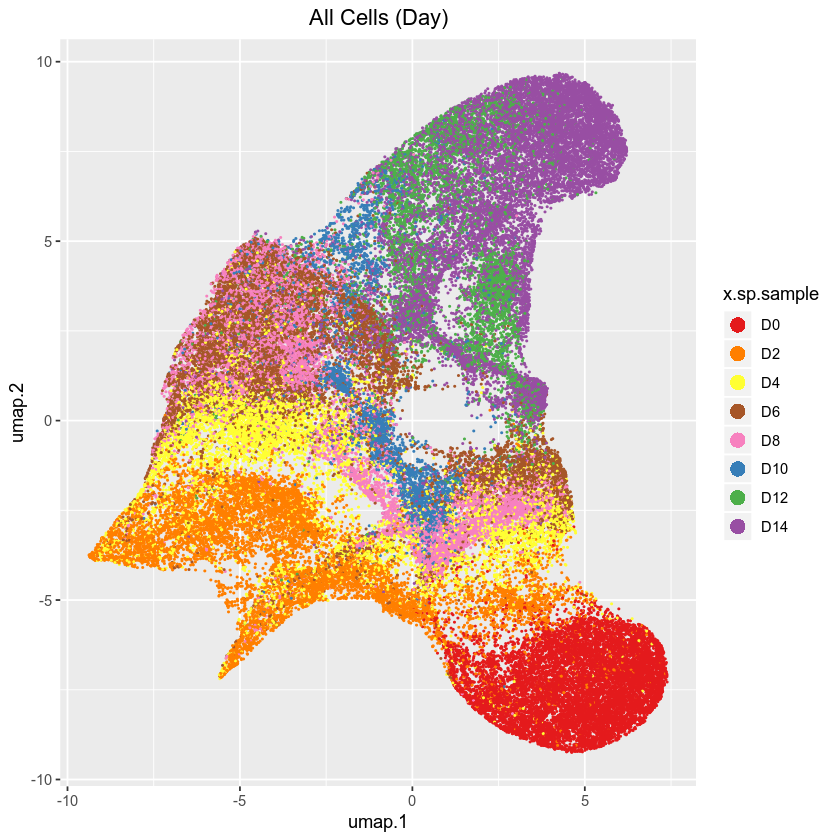

In [104]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [ ]:
day_cts = list()
for (i in seq(1,length(DAYS))) {
    cur = Matrix::colSums(x.sp[x.sp@sample==DAYS[i],]@pmat)
    day_cts[[i]] = cur
}

In [ ]:
day_cts = data.frame(day_cts)
colnames(day_cts) = DAYS
rownames(day_cts) = as.character(x.sp@peak)
head(day_cts)

In [ ]:
dim(day_cts)
day_cts = day_cts[rowSums(day_cts)>50, ]
dim(day_cts)

In [ ]:
dim(day_cts[rowSums(day_cts<100)==0,])
norm_cts = t(t(day_cts)/estimateSizeFactorsForMatrix(day_cts[rowSums(day_cts<100)==0,]))
head(norm_cts)

In [ ]:
log_norm_cts = log2(1+norm_cts)

In [ ]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = colnames(log_norm_cts)
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(clust_num),label=ID))+
geom_point(size=5)+
# scale_colour_manual() +
geom_text_repel(size=5)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

In [ ]:
cts_to_cluster = log_norm_cts 
# cts_to_cluster = t(scale(t(log_norm_cts)))

In [ ]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=15,
                        num_init = 10, 
                        verbose = FALSE)

In [ ]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

In [ ]:
table(pr_mb)

In [ ]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

In [ ]:
hist(as.vector(cts_clustered))

Saving 6.67 x 6.67 in image



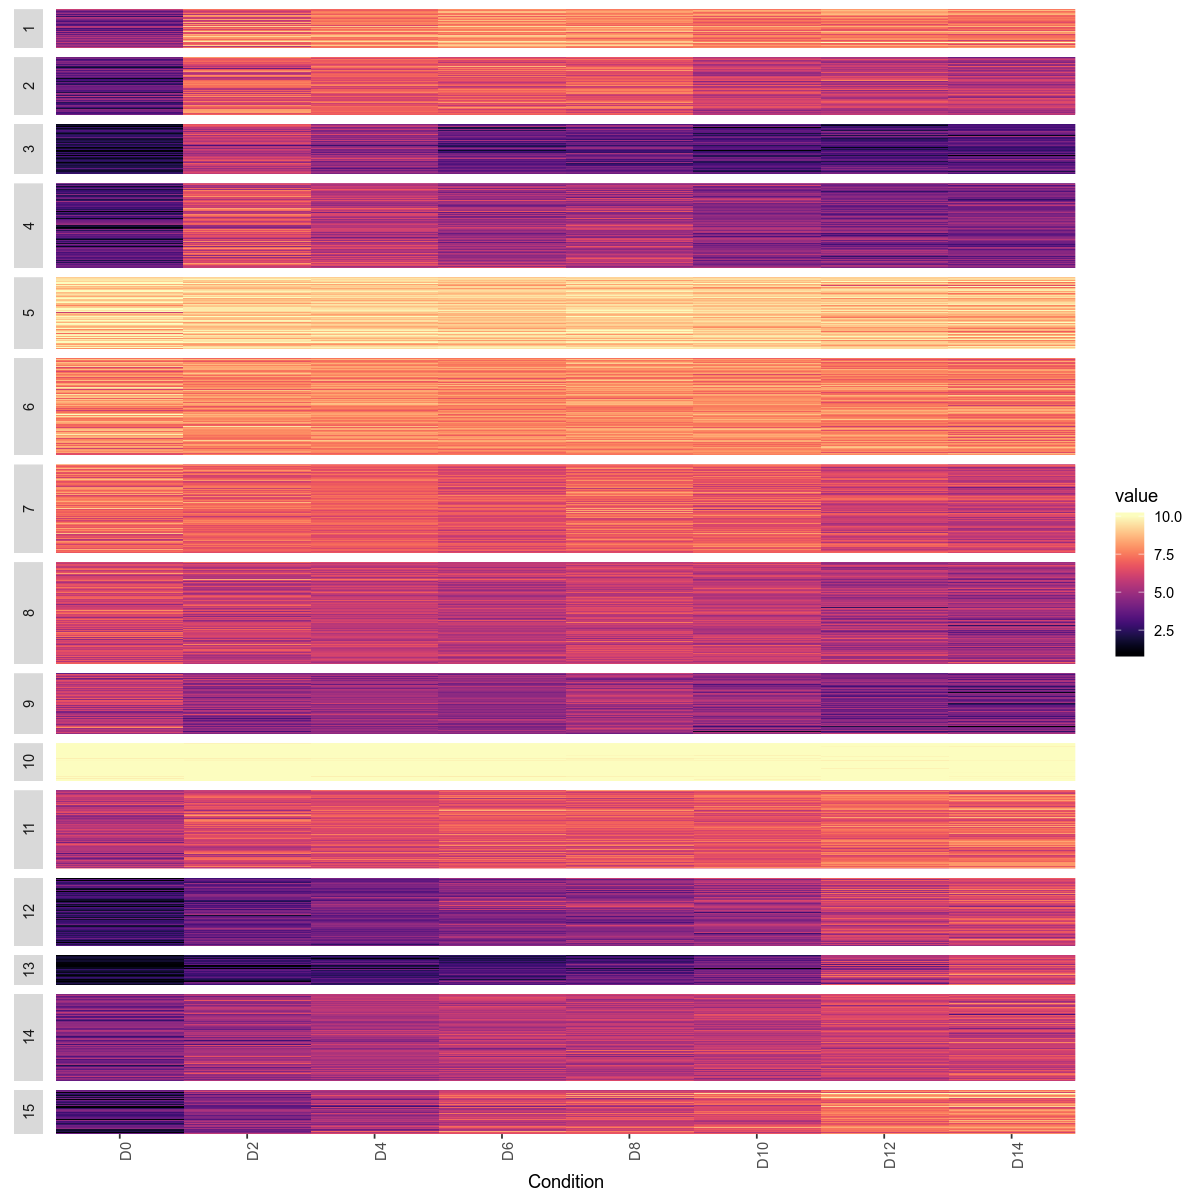

In [117]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs,]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(1, 10), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank()) +
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

ggsave(sprintf("figs/%s_heatmap_naive_bulk_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
       dpi=1000)

In [ ]:
tot_reads = Matrix::rowSums(x.sp@pmat)

In [1]:
cur_cluster_peaks = rownames(cts_to_cluster)[(which(pr_mb==2))]
length(cur_cluster_peaks)

ERROR: Error in rownames(cts_to_cluster): object 'cts_to_cluster' not found


In [2]:
fraction_in_cur_cluster = Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% cur_cluster_peaks])/tot_reads

ERROR: Error in Matrix::rowSums(x.sp@pmat[, as.character(x.sp@peak) %in% cur_cluster_peaks]): object 'x.sp' not found


In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)

hist(fraction_in_cur_cluster)

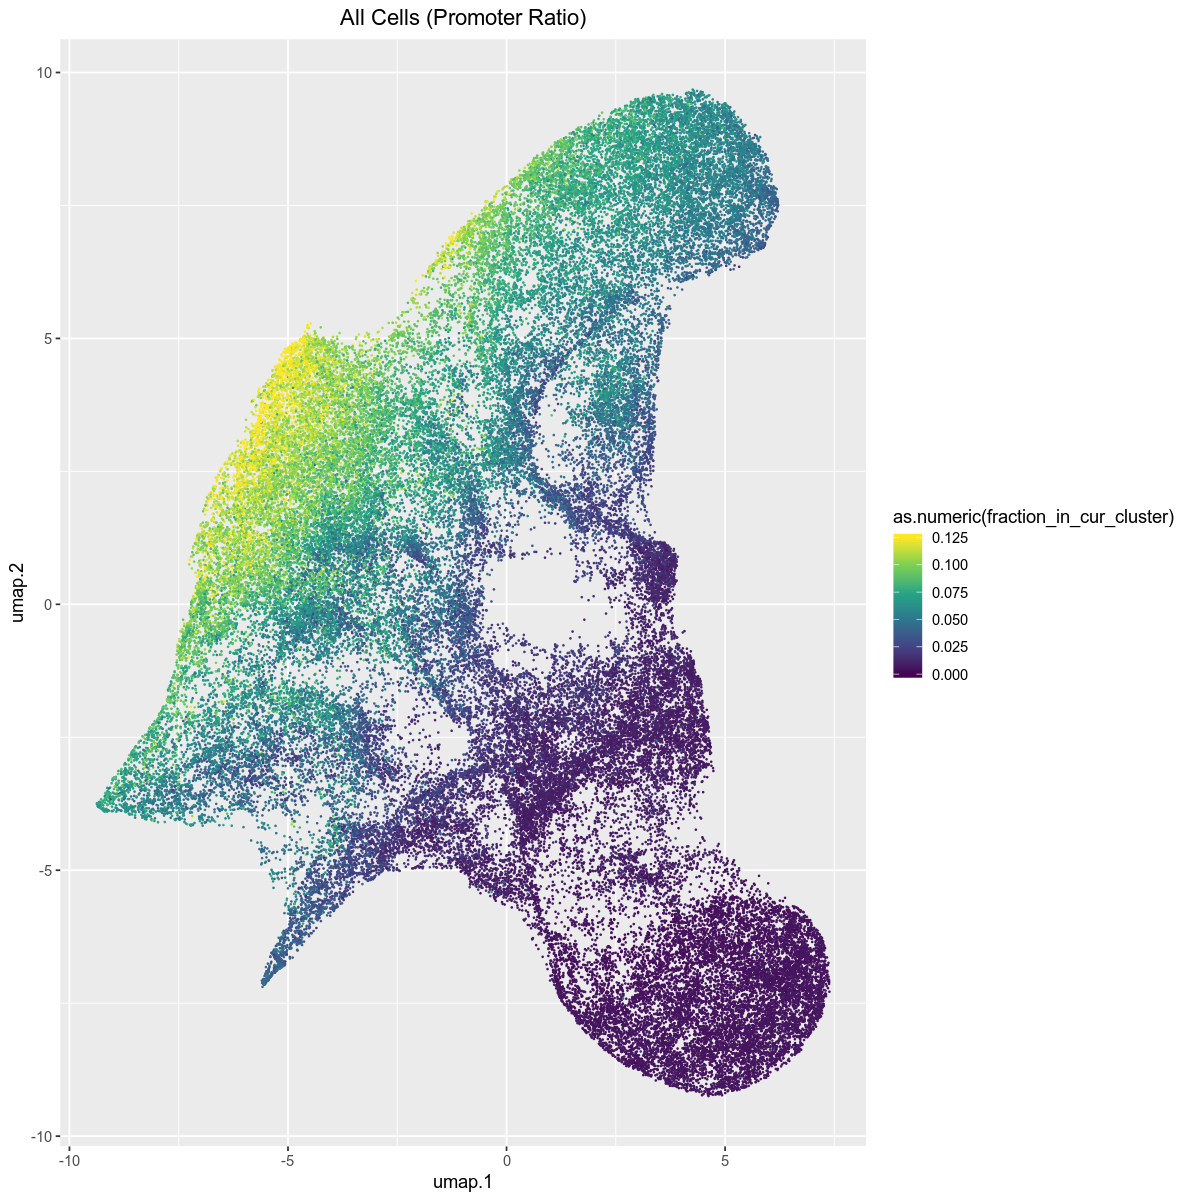

In [193]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, fraction_in_cur_cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(fraction_in_cur_cluster))) +
geom_point(size=0.1, alpha=1) +
scale_color_viridis_c(limits=c(0,quantile(fraction_in_cur_cluster, 0.99)), oob=squish) +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

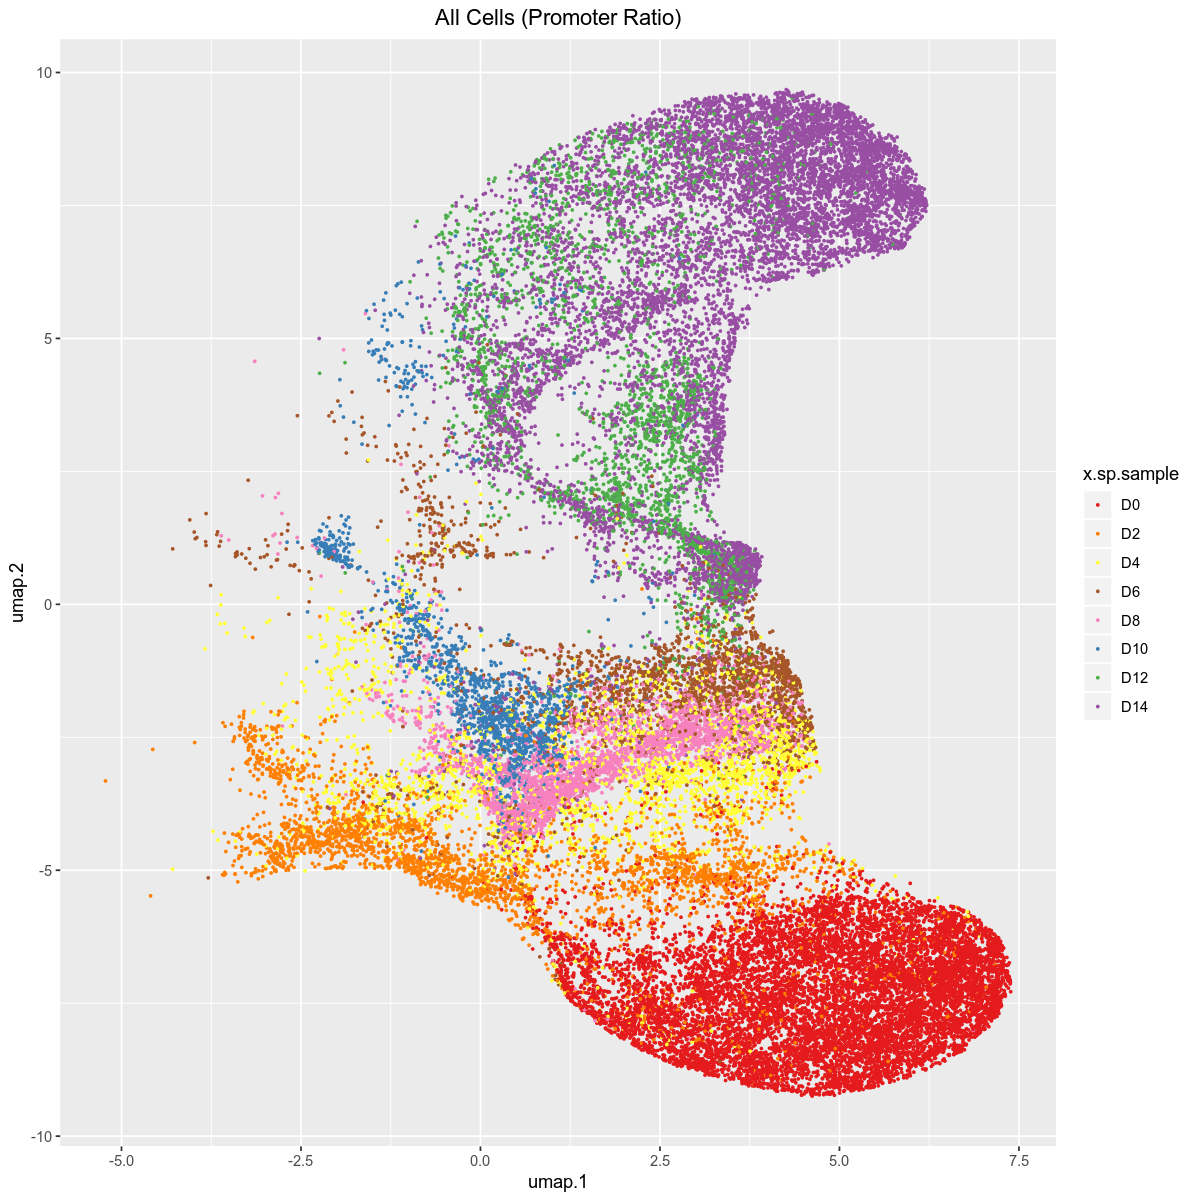

In [181]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(x.sp@umap, fraction_in_cur_cluster, x.sp@sample)
df = df[fraction_in_cur_cluster<quantile(fraction_in_cur_cluster,0.5), ]
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.sample)) +
geom_point(size=0.4, alpha=1) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

## Writing BED files for some clusters

In [114]:
CLUSTER_IDX = 1
NORM = 'heatmap_bulk'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200305_heatmap_bulk_n15/idx1.bed"

In [115]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster)))[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [116]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster))), fileConn)
close(fileConn)

[1] "beds/20200305_heatmap_bulk_n15/all_peaks.bed"


Commands for motif analysis:

```EXP=20200130_heatmap_idr_n20; for i in {1..4} ; do if [ ! -d homer/$EXP/idx$i ] ; then findMotifsGenome.pl beds/$EXP/idx$i.bed ~/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta homer/$EXP/idx$i -nomotif -size given -bg beds/$EXP/all_peaks.bed -p 8 ; fi ; done```